In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner

from impulse.base import PTSampler

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

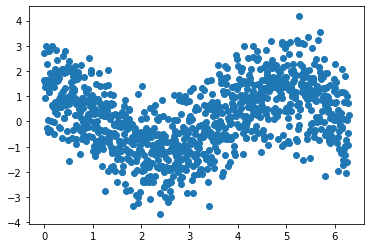

In [55]:
plt.scatter(x, data)

In [56]:
like = LnLikelihood(x, data)
prior = LnPrior([0, 0, 0], [3, 5, np.pi])

In [57]:
x0 = prior.initial_sample()
ndim = len(x0)

In [70]:
ntemps = 8
sampler = PTSampler(like, prior, [x0 for _ in range(ntemps)], tinf=True, num_samples=200_000, ntemps=ntemps, ncores=8, adapt_t0=1, adapt_nu=10, ret_chain=True)

In [71]:
chain = sampler.sample()

100%|██████████| 200/200 [02:40<00:00,  1.24it/s]


In [72]:
burn = int(0.25 * chain.shape[0])
omega = np.median(chain[burn:, 0, 0])
a = np.median(chain[burn:, 1, 0])
phi = np.median(chain[burn:, 2, 0])

In [73]:
print(omega, omega_real)
print(a, a_real)
print(phi, phi_real)

1.2516961253350092 1.2614020360700262
1.309881132184901 1.2581034381066862
1.6997693164698453 1.6150913673476284


In [74]:
with open('./chains/temp_data/temps.txt', 'r') as f:
    temps = np.loadtxt(f)

with open('./chains/temp_data/accept.txt', 'r') as f:
    accept = np.loadtxt(f)

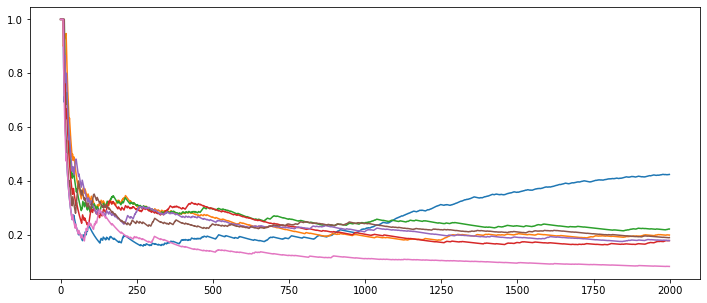

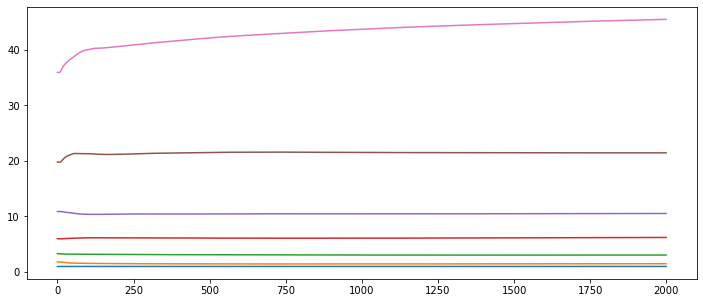

In [75]:
plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    # plt.plot(temps[:, ii])
    plt.plot(accept[:, ii])
plt.show()

plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    plt.plot(temps[:, ii])
    # plt.plot(accept[:, ii])
plt.show()

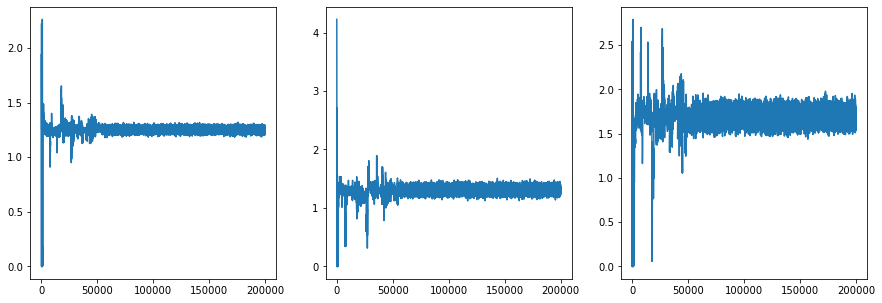

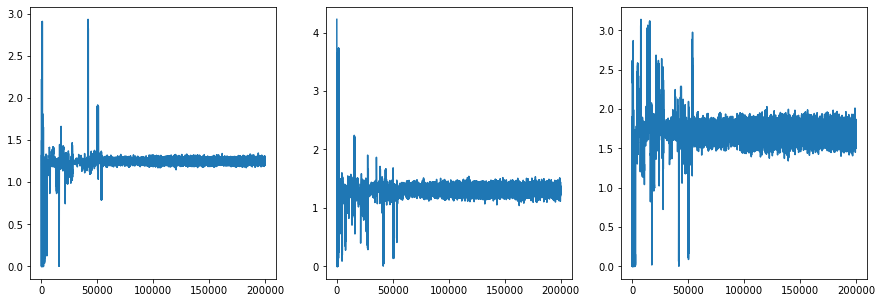

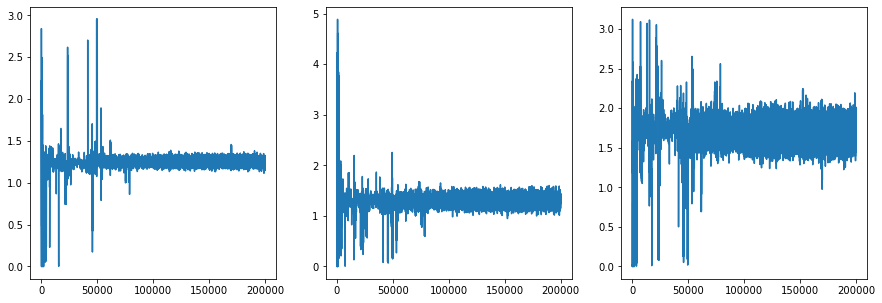

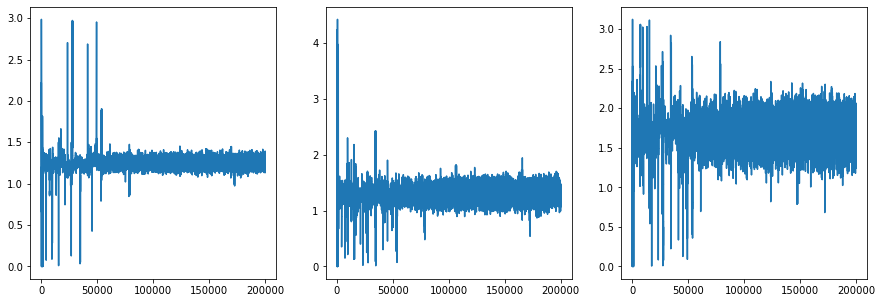

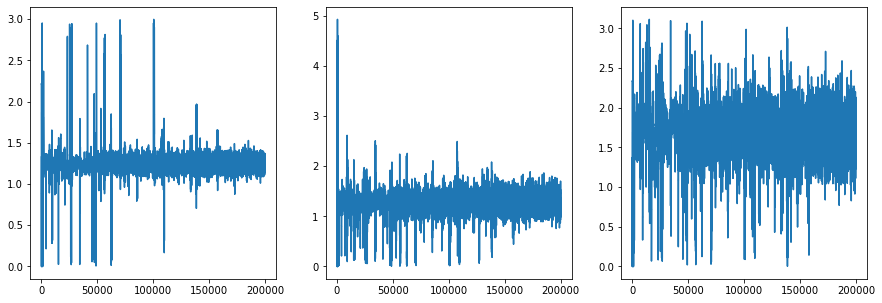

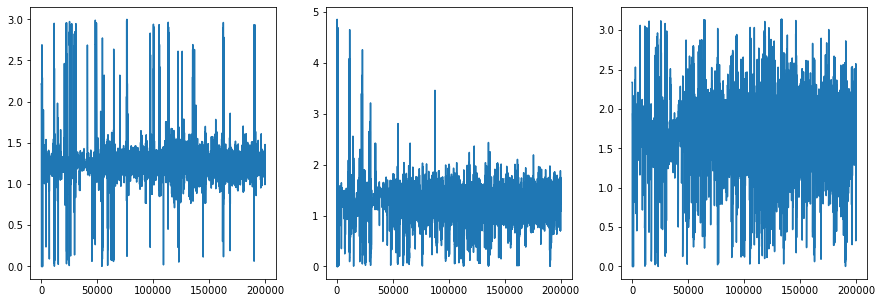

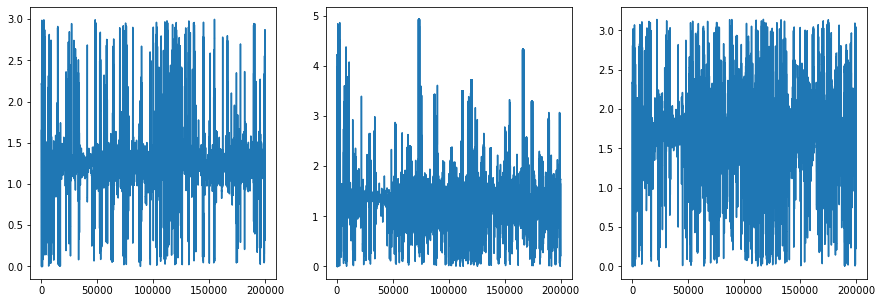

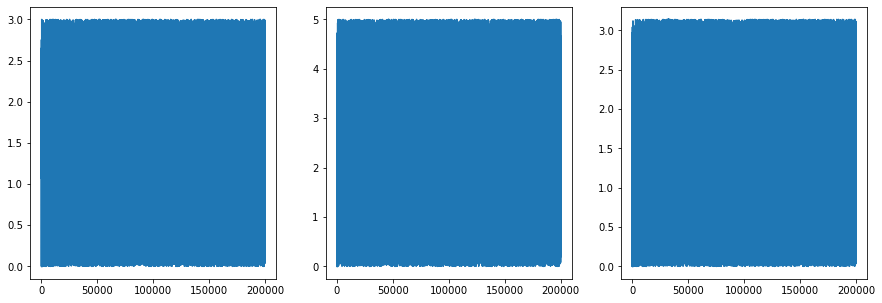

In [76]:
for ii in range(ntemps):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(chain[:, 0, ii])
    ax[1].plot(chain[:, 1, ii])
    ax[2].plot(chain[:, 2, ii])
    plt.show()

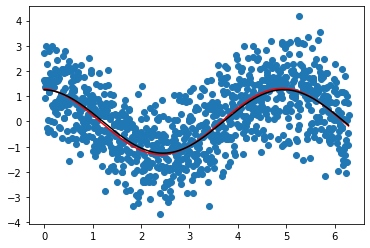

In [77]:
plt.scatter(x, data)
plt.plot(x, a * np.sin(omega * x + phi), color='red')
plt.plot(x, a_real * np.sin(omega_real * x + phi_real), color='black')

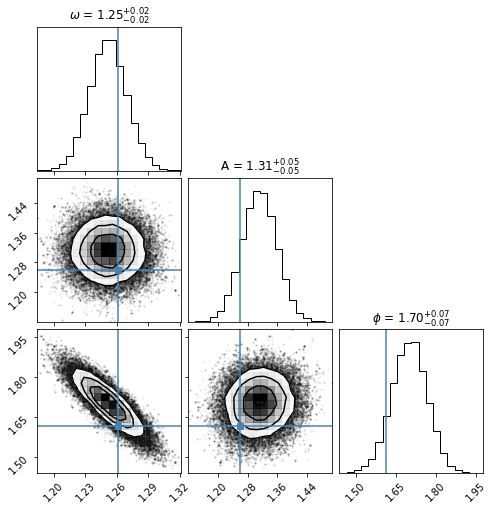

In [78]:
corner.corner(chain[2 * burn:, :, 0], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [69]:
print(omega_real, a_real, phi_real)
print(omega, a, phi)

1.2614020360700262 1.2581034381066862 1.6150913673476284
1.2516453026721526 1.3105724696529055 1.6992612262065916
